In [4]:
def log10_arg2_take2(x):
    from math import log10
    return 2 * log10(x)

print(log10_arg2_take2(1e155)) # Should work!
print(log10_arg2_take2(1e308)) # This one, too, even though 10^(308) is close the max possible float

310.0
616.0


In [5]:
import numpy as np

# By default, Numpy vectors constructed from a list are 1-D
# and have neither a row nor a column orientation.
z_array = np.array([1.0, 2.0, 3.0])

# By contrast, we want you to ensure your vectors are
# column vectors.
z_colvec = np.reshape(z_array, (len(z_array), 1))

print("`z_array`:\n\n", z_array, "\n\n==> shape:", z_array.shape)
print("\n")
print("`z_colvec`:\n\n", z_colvec, "\n\n==> shape:", z_colvec.shape)

`z_array`:

 [1. 2. 3.] 

==> shape: (3,)


`z_colvec`:

 [[1.]
 [2.]
 [3.]] 

==> shape: (3, 1)


In [6]:
# Data and computation
import numpy as np
import scipy as sp
import scipy.linalg
import pandas as pd

# Timing
from cse6040bench import benchit

# Viz
from IPython.display import display, Math
from matplotlib.pyplot import figure, subplot, xlim, ylim
from matplotlib.pyplot import scatter, axis, xlabel, ylabel, title, plot
%matplotlib inline

# Some functions we'll use later to display results
def show_cond_fancy(x, name, opt=''):
    """Display a condition number in 'fancy' format (using LaTeX)."""
    def sci_to_latex(x, fmt='{:.2e}'):
        s_raw = fmt.format(x)
        s, e = s_raw.split('e')
        return s + r'\times 10^{{{}}}'.format(int(e))
    from IPython.display import Math
    x_s = sci_to_latex(x)
    display(Math(r'\kappa({}){} \approx {}'.format(name, opt, x_s)))
    
def show_2vecs_tibble(x, y, xname='x', yname='y', error=False):
    """Display two column vectors side-by-side in a tibble."""
    assert type(x) is np.ndarray and x.ndim >= 2 and x.shape[1] == 1
    assert type(y) is np.ndarray and y.ndim >= 2 and y.shape[1] == 1
    assert x.shape == y.shape
    x_df = pd.DataFrame(x, columns=[xname])
    y_df = pd.DataFrame(y, columns=[yname])
    df = pd.concat([x_df, y_df], axis=1)
    if error:
        df['error'] = x - y
    display(df)
    
# Display (X, y) problem as a tibble
def make_data_tibble(X, y=None):
    df = pd.DataFrame(X, columns=['x_{}'.format(i) for i in range(X.shape[1])])
    if y is not None:
        y_df = pd.DataFrame(y, columns=['y'])
        df = pd.concat([y_df, df], axis=1)
    return df
    
# From: https://stackoverflow.com/questions/17129290/numpy-2d-and-1d-array-to-latex-bmatrix
def nparray_to_bmatrix(a):
    """Returns a LaTeX bmatrix"""
    assert len(a.shape) <= 2, 'bmatrix can at most display two dimensions'
    lines = str(a).replace('[', '').replace(']', '').splitlines()
    rv = [r'\begin{bmatrix}']
    rv += ['  ' + ' & '.join(l.split()) + r'\\' for l in lines]
    rv +=  [r'\end{bmatrix}']
    return '\n'.join(rv)

# Stash this function for later:
SAVE_LSTSQ = np.linalg.lstsq # You may ignore this line, which some test cells will use

Matplotlib is building the font cache; this may take a moment.


In [7]:
def gen_problem(m, n):
    from numpy import arange, tile, cumprod, insert, ones
    # 1 + x + x^2 + ... + x^n, x = 0:m
    X = np.empty((m, n+1))
    x_col = arange(m).reshape((m, 1)) # 0, 1, 2, ..., m-1
    X[:, 0] = 1.0
    X[:, 1:] = tile(x_col, reps=(1, n))
    X[:, 1:] = cumprod(X[:, 1:], axis=1)
    theta = ones((n+1, 1))
    y = np.sum(X, axis=1).reshape((m, 1))
    return X, y, theta

print("Sample generated problem:")
m, n = 10, 2
X, y, theta_true = gen_problem(m, n)

display(Math(r'X = {}, \quad y = {} \quad \implies \quad \theta^* = {}'.format(nparray_to_bmatrix(X),
                                                                               nparray_to_bmatrix(y),
                                                                               nparray_to_bmatrix(theta_true))))

Sample generated problem:


<IPython.core.display.Math object>

In [18]:
def calc_residual_norm(X, y, theta):
    residual = X.dot(theta) - y
    return np.linalg.norm(residual)

r_norm_neq = calc_residual_norm(X, y, theta_neq)
print("\nThe squared residual norm:", r_norm_neq)


The squared residual norm: 3.513658552879787e-14


In [20]:
def random_mat (m, n, eps):
    return np.random.uniform(0, eps, (m, n))

print(random_mat(3, 2, 1e-3))

[[6.66546779e-04 1.57439720e-05]
 [2.97632425e-04 3.46124218e-04]
 [8.02628022e-04 3.01188949e-04]]


In [22]:
def perturb_system(X, y, eps):
    delta_X = np.random.uniform(-eps, eps, X.shape)
    delta_y = np.random.uniform(-eps, eps, y.shape)
    
    return X + delta_X, y + delta_y


EPSILON = 0.1
X_perturbed, y_perturbed = perturb_system(X, y, EPSILON)

Delta_X = X_perturbed - X
Delta_y = y_perturbed - y
display(Math(r'\Delta X = {}, \quad \Delta y = {}'.format(nparray_to_bmatrix(Delta_X[:5, :]),
                                                          nparray_to_bmatrix(Delta_y[:5]))))

<IPython.core.display.Math object>

In [24]:
def run_perturbation_trials(solver, X, y, eps=0.01, trials=100):
    Thetas = np.zeros((X.shape[1], trials)) # Store all computed thetas
    for t in range(trials):
        X_p, y_p = perturb_system(X, y, eps)
        Thetas[:, t:t+1] = solver(X_p, y_p)
    return Thetas

Thetas_neq = run_perturbation_trials(solve_neq, X, y)

print("Unperturbed solution:")
print(theta_neq)

print("First few perturbed solutions (columns):")
print(Thetas_neq[:, :5])

Unperturbed solution:
[[1.]
 [1.]
 [1.]]
First few perturbed solutions (columns):
[[1.00455886 1.00101007 0.98984514 0.99225538 1.01298014]
 [0.99984949 0.99800456 1.00294895 1.00030071 0.99313711]
 [0.99996111 1.00027414 0.99984266 1.00014391 1.00077193]]


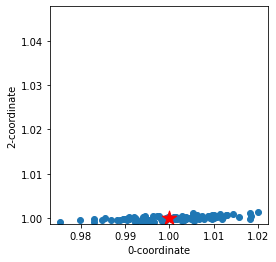

In [25]:
# Makes a 2-D scatter plot of given theta values.
# If the thetas have more than two dimensions, only
# the first and last are displayed by default.
# (Override by setting ax and ay.)

def scatter_thetas(Thetas, theta_true=None, ax=0, ay=-1, xylim=None, title=None):
    import matplotlib.pyplot as plt
    assert type(Thetas) is np.ndarray and Thetas.shape[0] >= 2
    scatter(Thetas[ax, :], Thetas[ay, :])
    xlabel('{}-coordinate'.format(ax if ax >= 0 else Thetas.shape[0]+ax))
    ylabel('{}-coordinate'.format(ay if ay >= 0 else Thetas.shape[0]+ay))
    if xylim is not None:
        axis(xylim)
    else:
        axis('equal')
    if theta_true is not None:
        assert type(theta_true) is np.ndarray and theta_true.shape[0] >= 2 and theta_true.shape[1] == 1
        scatter(theta_true[ax], theta_true[ay], marker='*', color='red', s=15**2)
    if title is not None:
        plt.title(title)
        
def calc_lims(x, buffer=0.1):
    xmin = x.min()
    xmax = x.max()
    dx = (xmax - xmin) * buffer
    return xmin-dx, xmax+dx
        
scatter_thetas(Thetas_neq, theta_true=theta_true, ax=0, ay=2)
axis('square');

In [26]:
cond_X = np.linalg.cond(X)
cond_XTX = np.linalg.cond(X.T.dot(X))

assert 1. <= cond_X <= 3e3
assert 1. <= cond_XTX <= 6e6

show_cond_fancy(cond_X, 'X')
show_cond_fancy(cond_XTX, 'X^T X')
show_cond_fancy(cond_X**2, 'X', opt='^2')

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [27]:
# Generate a "hard" problem
m_hard, n_hard = 100, 6
X_hard, y_hard, theta_hard_true = gen_problem(m_hard, n_hard)

df_hard = make_data_tibble(X_hard, y_hard)
print("First few rows of data:")
df_hard.head()
print("True parameter estimates:\n{}".format(theta_hard_true))

cond_X_hard = np.linalg.cond(X_hard)
cond_XTX_hard = np.linalg.cond(X_hard.T.dot(X_hard))

name_X_hard = 'X_h'
show_cond_fancy(cond_X_hard, name_X_hard)
show_cond_fancy(cond_XTX_hard, '{}^T {}'.format(name_X_hard, name_X_hard))

First few rows of data:
True parameter estimates:
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Residual norm for one of the trials:


<ipython-input-12-1462ae842354>:4: LinAlgWarning: Ill-conditioned matrix (rcond=2.82991e-25): result may not be accurate.
  return scipy.linalg.solve(C, b)
<ipython-input-12-1462ae842354>:4: LinAlgWarning: Ill-conditioned matrix (rcond=2.79887e-25): result may not be accurate.
  return scipy.linalg.solve(C, b)
<ipython-input-12-1462ae842354>:4: LinAlgWarning: Ill-conditioned matrix (rcond=2.77785e-25): result may not be accurate.
  return scipy.linalg.solve(C, b)
<ipython-input-12-1462ae842354>:4: LinAlgWarning: Ill-conditioned matrix (rcond=2.79765e-25): result may not be accurate.
  return scipy.linalg.solve(C, b)
<ipython-input-12-1462ae842354>:4: LinAlgWarning: Ill-conditioned matrix (rcond=2.7603e-25): result may not be accurate.
  return scipy.linalg.solve(C, b)
<ipython-input-12-1462ae842354>:4: LinAlgWarning: Ill-conditioned matrix (rcond=2.84164e-25): result may not be accurate.
  return scipy.linalg.solve(C, b)
<ipython-input-12-1462ae842354>:4: LinAlgWarning: Ill-conditioned

212070531298449.12

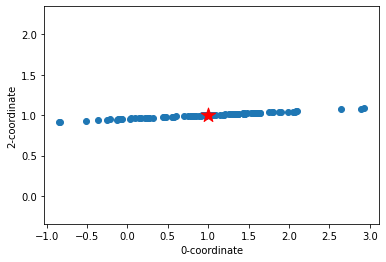

In [28]:
Thetas_hard_neq = run_perturbation_trials(solve_neq, X_hard, y_hard)
scatter_thetas(Thetas_hard_neq, theta_true=theta_hard_true, ax=0, ay=2)

print("Residual norm for one of the trials:")
theta_hard_neq_example = np.random.randint(Thetas_hard_neq.shape[1])
calc_residual_norm(X_hard, y_hard, theta_hard_neq_example)

In [29]:
theta_hard_neq_example

80

In [30]:
print(X[:5], "\n ...\n")

Q, R = np.linalg.qr(X)

# Print the dimensions of your result
print("Q:", Q.shape, "\n")
print("R:", R.shape, "==")
print(Q)

[[ 1.  0.  0.]
 [ 1.  1.  1.]
 [ 1.  2.  4.]
 [ 1.  3.  9.]
 [ 1.  4. 16.]] 
 ...

Q: (10, 3) 

R: (3, 3) ==
[[-0.31622777 -0.49543369  0.52223297]
 [-0.31622777 -0.38533732  0.17407766]
 [-0.31622777 -0.27524094 -0.08703883]
 [-0.31622777 -0.16514456 -0.26111648]
 [-0.31622777 -0.05504819 -0.34815531]
 [-0.31622777  0.05504819 -0.34815531]
 [-0.31622777  0.16514456 -0.26111648]
 [-0.31622777  0.27524094 -0.08703883]
 [-0.31622777  0.38533732  0.17407766]
 [-0.31622777  0.49543369  0.52223297]]


In [32]:
cond_R = np.linalg.cond(R)

show_cond_fancy(cond_X, 'X')
show_cond_fancy(cond_XTX, 'X^T X')
show_cond_fancy(cond_R, 'R')

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [34]:
import scipy.linalg

def solve_qr(X, y):
    Q, R = np.linalg.qr(X)
    z = Q.T @ y
    theta = scipy.linalg.solve_triangular(R, z, lower=False)
    return theta
    
theta_qr = solve_qr(X, y)

print("Comparing your QR solution to the true solution:")
show_2vecs_tibble(theta_qr, theta_true, xname='theta_qr', yname='theta_true', error=True)

print("Residual norm:")
calc_residual_norm(X, y, theta_qr)

Comparing your QR solution to the true solution:


,theta_qr,theta_true,error
0,1.0,1.0,-7.216450e-15
1,1.0,1.0,5.107026e-15
2,1.0,1.0,-7.771561e-16


Residual norm:


3.428720300574628e-14

Sample estimate for one of the trials:
- Gramian-based method: theta^T =
	[1.19633263 0.92660112 1.00684227 0.99974036 1.00000468 0.99999996
 1.        ]
- QR-based method: theta^T =
	[1.00498269 0.99890713 1.00003479 1.00000045 0.99999996 1.
 1.        ]


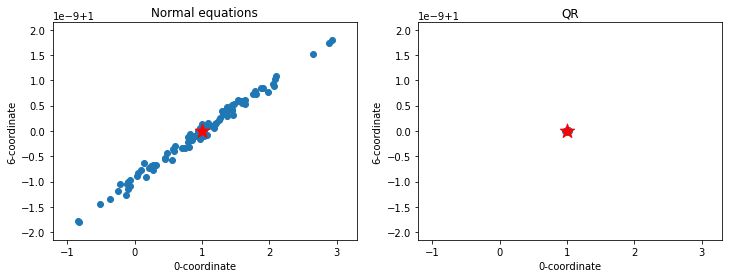

In [36]:
Thetas_hard_qr = run_perturbation_trials(solve_qr, X_hard, y_hard)

# Plot side-by-side against normal equations method
def compare_scatter_thetas(T0, title0, T1, title1, ax=0, ay=1, **kwargs):
    xmin, xmax = calc_lims(np.array([Thetas_hard_neq[ax, :], Thetas_hard_qr[ax, :]]))
    ymin, ymax = calc_lims(np.array([Thetas_hard_neq[ay, :], Thetas_hard_qr[ay, :]]))
    xylim = [xmin, xmax, ymin, ymax]
    figure(figsize=(12, 4))
    subplot(1, 2, 1)
    scatter_thetas(T0, title=title0, ax=ax, ay=ay, xylim=xylim, **kwargs)
    subplot(1, 2 ,2)
    scatter_thetas(T1, title=title1, ax=ax, ay=ay, xylim=xylim, **kwargs)
    
compare_scatter_thetas(Thetas_hard_neq, 'Normal equations',
                       Thetas_hard_qr, 'QR',
                       ax=0, ay=-1, theta_true=theta_hard_true)

print("Sample estimate for one of the trials:")
theta_hard_neq_example = Thetas_hard_neq[:, np.random.randint(Thetas_hard_neq.shape[1])]
theta_hard_qr_example = Thetas_hard_qr[:, np.random.randint(Thetas_hard_qr.shape[1])]
msg = "- {}-based method: theta^T =\n\t{}"
print(msg.format("Gramian", theta_hard_neq_example.T))
print(msg.format("QR", theta_hard_qr_example.T))

In [37]:
print("=== Performance of the normal equations-based algorithm ===")
benchit("solve_neq(X_hard, y_hard)", scope=globals());

=== Performance of the normal equations-based algorithm ===


<ipython-input-12-1462ae842354>:4: LinAlgWarning: Ill-conditioned matrix (rcond=2.8027e-25): result may not be accurate.
  return scipy.linalg.solve(C, b)


Timing result: (5 trials) x (10000 runs) in 3.5985530919997473 secs
==> 7.197106183999494e-05 secs per run


In [38]:
print("\n=== Performance of the QR-based algorithm ===")
benchit("solve_qr(X_hard, y_hard)", scope=globals());


=== Performance of the QR-based algorithm ===
Timing result: (5 trials) x (10000 runs) in 4.827964314999917 secs
==> 9.655928629999835e-05 secs per run
